In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from google.colab import files 
## Upload 'icu_data.csv' 
files.upload();

Saving icu_data.csv to icu_data.csv


In [3]:
df = pd.read_csv("icu_data.csv")

## take out outcome variables
outcomevars = ["mort_icu","mort7","mort30","mort90","mort180","max_SOFA"]
dfout = df[ outcomevars ]

## remove unwanted columns from explanatory variables
to_remove = outcomevars + ["Unnamed: 0", "uo_d1"]
for var in df.columns:
    if var.find('_d') > -1 and var.find('_d1') == -1:
        to_remove.append(var)
df = df.drop( columns = to_remove )

## set NIV values in mech_vent_d1 to nan, and convert to int64
df.loc[ df["mech_vent_d1"] == "NIV", "mech_vent_d1"] = np.nan
df["mech_vent_d1"] = df["mech_vent_d1"].astype('float')

## now build predictors and outcome
X = df
y = dfout["mort7"]

## remove records without outcome
X = X[ np.isfinite(y) ]
y = y[ np.isfinite(y) ]

## impute missing values using median; don't use a pipeline, just apply SimpleImputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X, y)
Ximp = imp.transform(X)

In [19]:
## Our baseline model: logistic regression, with optimized L1 penalty (see yesterday)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model1 = LogisticRegression(C=10**-2.2, solver='saga', penalty='l1', max_iter=10000)
model1.fit(Ximp, y)

def score_model(model, X, y):
  scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  print("%0.3f AUC with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

score_model(model1, Ximp, y)

0.755 AUC with a standard deviation of 0.043


In [20]:
from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier(n_neighbors = 80)
score_model(model2, Ximp, y)

0.647 AUC with a standard deviation of 0.071


In [21]:
from sklearn.naive_bayes import GaussianNB

model3 = GaussianNB()
score_model(model3, Ximp, y)

0.733 AUC with a standard deviation of 0.037


In [22]:
from sklearn.svm import SVC

model4 = SVC(C=1000)
score_model(model4, Ximp, y)

0.732 AUC with a standard deviation of 0.028


In [23]:
from sklearn.tree import DecisionTreeClassifier
model5 = DecisionTreeClassifier()
score_model(model5, Ximp, y)

0.576 AUC with a standard deviation of 0.030


In [24]:
from sklearn.ensemble import RandomForestClassifier
model6 = RandomForestClassifier()
score_model(model6, Ximp, y)

0.760 AUC with a standard deviation of 0.019


In [25]:
from sklearn.ensemble import AdaBoostClassifier
model7 = AdaBoostClassifier()
score_model(model7, Ximp, y)

0.725 AUC with a standard deviation of 0.035


In [26]:
from xgboost import XGBClassifier
model8 = XGBClassifier()
score_model(model8, Ximp, y)

0.778 AUC with a standard deviation of 0.028


In [27]:
from sklearn.neural_network import MLPClassifier

model9 = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(2, 2), random_state=1, max_iter=10000)
score_model(model9, Ximp, y)

0.499 AUC with a standard deviation of 0.013


In [29]:
## Optimized using the code below (for Xscaled)

model10 = MLPClassifier(solver='adam', alpha=10**-1.5, activation = 'logistic', hidden_layer_sizes=(3, 2), random_state=1, max_iter=10000)
score_model(model10, Ximp, y)

0.577 AUC with a standard deviation of 0.042


In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(Ximp, y)
Xscaled = sc.transform(Ximp)

results = pd.DataFrame( columns = ["Model", "AUC", "sd", "AUC_scaled", "sd_scaled"] )

def calculate_score(model, X, y):
  scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
  return scores.mean(), scores.std()

for idx, model in enumerate([model1, model2, model3, model4, model5, model6, model7, model8, model9, model10]):
  modelname = type(model).__name__
  auc, sd = calculate_score(model, Ximp, y)
  auc_scaled, sd_scaled = calculate_score(model, Xscaled, y)
  results.loc[idx] = [modelname, auc, sd, auc_scaled, sd_scaled]

results

,Model,AUC,sd,AUC_scaled,sd_scaled
0,LogisticRegression,0.755186,0.042792,0.500000,0.000000
1,KNeighborsClassifier,0.646781,0.071189,0.743334,0.059557
2,GaussianNB,0.732564,0.036637,0.732394,0.036746
3,SVC,0.732296,0.028388,0.671501,0.063247
4,DecisionTreeClassifier,0.580988,0.041865,0.598095,0.038606
5,RandomForestClassifier,0.772817,0.020901,0.770212,0.024016
6,AdaBoostClassifier,0.724519,0.034741,0.724434,0.034597
7,XGBClassifier,0.778006,0.027796,0.777963,0.028006
8,MLPClassifier,0.499450,0.012600,0.701743,0.064377
9,MLPClassifier,0.576662,0.042052,0.787383,0.015351


0.787 AUC with a standard deviation of 0.018


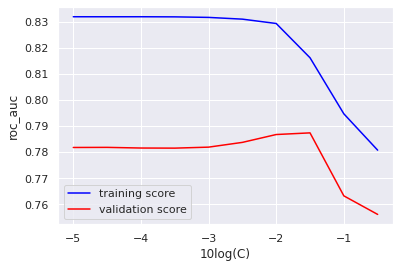

In [18]:
## Code to optimize the hyperparameters of the MPLClassifier, partly "by hand"

from sklearn.neural_network import MLPClassifier

model9 = MLPClassifier(solver='adam', alpha=10**-1.5, activation = 'logistic', hidden_layer_sizes=(3, 2), random_state=1, max_iter=10000)
score_model(model9, Xscaled, y)

from sklearn.model_selection import validation_curve
from math import log

## for alpha
vals = np.power(10.0, np.arange(-5,0,0.5))
plotvals = np.log(vals) / log(10.0)
param = "alpha"

# for hidden_layer_sizes
#plotvals = [k for k in range(1,10)]
#vals = [ (2,k) for k in plotvals ]
#vals = [ (k,2) for k in plotvals ]
#param = "hidden_layer_sizes"

scoring='roc_auc'

train_scores, test_scores = validation_curve(model9, Xscaled, y, 
                                             param_name = param, param_range = vals, cv=5, scoring=scoring)

plt.plot(plotvals, np.mean (train_scores, 1), color='blue', label='training score')
plt.plot(plotvals, np.mean(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('10log(C)')
plt.ylabel(scoring);